Import Library

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

Define a function to load audio files and extract MFCC features

In [2]:
def load_audio_files(path):
    audio_files = []
    labels = []
    if 'fake' in path:
        label = [1.0, 0.0]
    else:
        label = [0.0, 1.0]
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        audio, sr = librosa.load(file_path, sr=44100)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = 220 - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
        audio_files.append(mfccs)
        labels.append(label)
    return audio_files, labels

Set the path to the dataset directory

In [3]:
dataset_path = "for-rerec"

Load the training set

In [4]:
train_path = os.path.join(dataset_path, "training")
train_fake_path = os.path.join(train_path, "fake")
train_real_path = os.path.join(train_path, "real")
train_fake_files, train_fake_labels = load_audio_files(train_fake_path)
train_real_files, train_real_labels = load_audio_files(train_real_path)

Load the validation set

In [5]:
val_path = os.path.join(dataset_path, "validation")
val_fake_path = os.path.join(val_path, "fake")
val_real_path = os.path.join(val_path, "real")
val_fake_files, val_fake_labels = load_audio_files(val_fake_path)
val_real_files, val_real_labels = load_audio_files(val_real_path)

Load the testing set

In [6]:
test_path = os.path.join(dataset_path, "testing")
test_fake_path = os.path.join(test_path, "fake")
test_real_path = os.path.join(test_path, "real")
test_fake_files, test_fake_labels = load_audio_files(test_fake_path)
test_real_files, test_real_labels = load_audio_files(test_real_path)

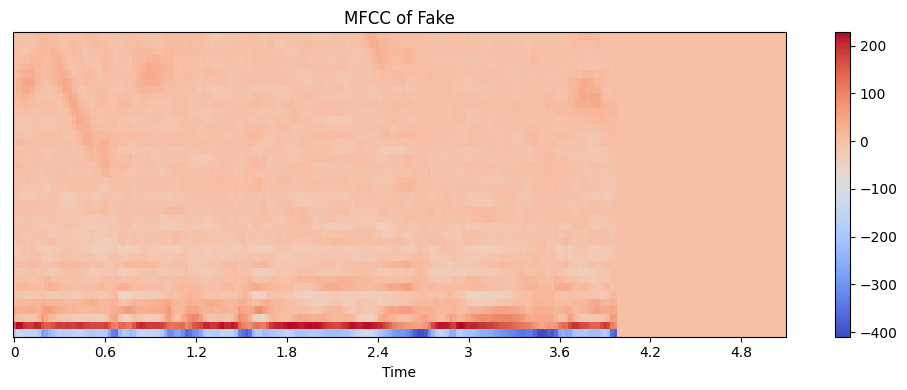

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_fake_files[0], x_axis='time')
plt.colorbar()
plt.title('MFCC of Fake')
plt.tight_layout()
plt.show()

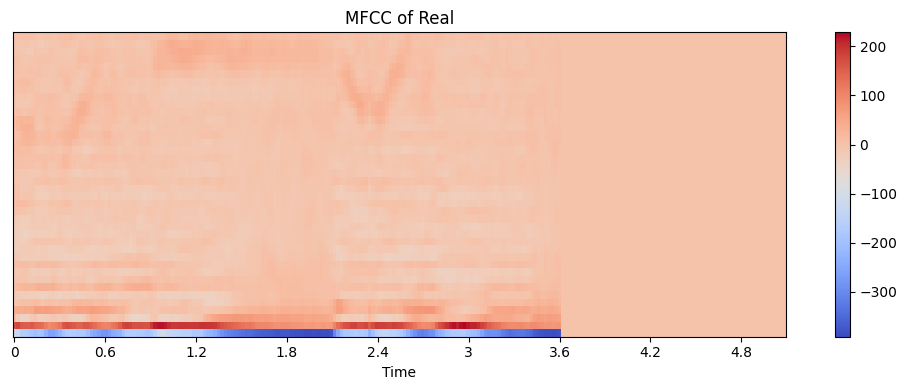

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_real_files[0], x_axis='time')
plt.colorbar()
plt.title('MFCC of Real')
plt.tight_layout()
plt.show()

Combine fake and real sets to the train, test and validation sets

In [9]:
def combinedata(realfile, fakefile, reallabel, fakelabel):
    X = []
    Y = []
    for elem in realfile:
        X.append(elem)
    for elem in fakefile:
        X.append(elem)
    for elem in reallabel:
        Y.append(elem)
    for elem in fakelabel:
        Y.append(elem)
    return X, Y

In [10]:
X_train, Y_train = combinedata(train_real_files, train_fake_files, train_real_labels, train_fake_labels)

In [11]:
X_val, Y_val = combinedata(val_real_files, val_fake_files, val_real_labels, val_fake_labels)

In [12]:
X_test, Y_test = combinedata(test_real_files, test_fake_files, test_real_labels, test_fake_labels)

In [13]:
len(X_train), len(Y_train), len(X_val), len(Y_val), len(X_test), len(Y_test)

(10208, 10208, 2244, 2244, 816, 816)

Add Channel dimension for CNN

In [14]:
X_train = np.array(X_train, dtype='object')
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.array(X_val, dtype='object')
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.array(X_test, dtype='object')
X_test = np.reshape(X_test, (*X_test.shape, 1))

In [15]:
Y_train = np.array(Y_train, dtype='object')
Y_val = np.array(Y_val, dtype='object')
Y_test = np.array(Y_test, dtype='object')

Define the model

In [16]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((10208, 40, 220, 1), (2244, 40, 220, 1), (10208, 2), (2244, 2))

In [17]:
input_shape = (40, 220, 1)

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

Compile the model

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 218, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 109, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 107, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 53, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 27136)             0         
                                                                 
 dense (Dense)               (None, 128)               3

Train the model

Fit the model with the updated data

In [21]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

In [22]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
319/319 [==============================] - 407s 1s/step - loss: 1.2411 - accuracy: 0.8035 - val_loss: 0.1989 - val_accuracy: 0.9242
Epoch 2/50
319/319 [==============================] - 404s 1s/step - loss: 0.1867 - accuracy: 0.9285 - val_loss: 0.2100 - val_accuracy: 0.9184
Epoch 3/50
319/319 [==============================] - 401s 1s/step - loss: 0.1404 - accuracy: 0.9455 - val_loss: 0.2250 - val_accuracy: 0.9158
Epoch 4/50
319/319 [==============================] - 402s 1s/step - loss: 0.0977 - accuracy: 0.9629 - val_loss: 0.1403 - val_accuracy: 0.9541
Epoch 5/50
319/319 [==============================] - 400s 1s/step - loss: 0.0606 - accuracy: 0.9781 - val_loss: 0.2057 - val_accuracy: 0.9407
Epoch 6/50
319/319 [==============================] - 399s 1s/step - loss: 0.0459 - accuracy: 0.9840 - val_loss: 0.1490 - val_accuracy: 0.9563
Epoch 7/50
319/319 [==============================] - 400s 1s/step - loss: 0.0304 - accuracy: 0.9888 - val_loss: 0.1487 - val_accuracy: 0.9608

Evaluate the model on the test set

In [23]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Test accuracy:', test_acc)

26/26 [==============================] - 10s 398ms/step - loss: 0.8955 - accuracy: 0.8578
Test accuracy: 0.8578431606292725
